In [23]:
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
import seaborn as sns
import os
import openpyxl

load files. Files can be downloaded from zenodo: https://zenodo.org/record/7004556#.Yzm6OnZBztU. File paths should be adjusted to the download locations.

In [24]:
cellfilenames=glob(r'C:\Bud annotation\CONTROL\MASKS\cell masks\*') #<-- folder with cell masks
budfilenames=glob(r'C:\Bud annotation\CONTROL\MASKS\bud masks\*') #<-- folder with bud masks
textfile = r'C:\Bud annotation\Spot analysis results FISHQUANT\CONTROL_CY35_FISH-QUANT__threshold_spots_220518.txt' #<-- path to file with spot info - file name ends with _FISH-QUANT__threshold_spots_YYMMDD.txt

q = pd.read_csv(textfile, skiprows=13, sep='\t')

#### Extract needed info into dataframe

In [25]:
q = q[['File','Cell','X_det','Y_det','INT_filt']]

q.to_excel(r'C:\Bud annotation\CONTROL\Spot analysis results FISHQUANT\CONTROL_CY35_q.xlsx')

#### Divides the filtered intensity by the average intensity value of a single mRNA = the mean of the Gaussian denisity distribution

In [26]:
number_spots = round(q['INT_filt'].div(1728)) #<-- insert average intensity value 
number_spots.values[number_spots <1]= 1 
q['number_spots'] = number_spots
q
q.to_excel(r'C:\Users\Evelina\Desktop\Bud annotation GItHub\CONTROL\Spot analysis results FISHQUANT\CONTROL_CY35_q2.xlsx')

#### Loops through the bud and cell masks and counts spots in these coordinates

In [27]:
d={}
for cellfilename in cellfilenames:
    root,filename=os.path.split(cellfilename)
    rfilename=filename.rpartition('_MASK')[0]
    cell_img=io.imread(cellfilename)
    labels=set(cell_img.ravel())-{0}
    for label in labels:
        unique_ID=f'{rfilename}+{label}'
        d[unique_ID]=[0,0,0,0]

In [28]:
for budfilename in budfilenames:
            root,filename=os.path.split(budfilename)
            rfilename=filename.rpartition('_MASK')[0]
            print(rfilename)

CONTROL_01
CONTROL_02
CONTROL_03


#### Adds spots to cell and bud dataframes

In [29]:
for ix,row in q.iterrows():
    if ix==0:
        previous=0
    if previous!=row['File']:
        print(row['File'])
        for cellfilename in cellfilenames:
            root,filename=os.path.split(cellfilename)
            rfilename=filename.rpartition('_MASK')[0]
            if row['File'].rpartition('_')[0]==rfilename:
                cell_img=io.imread(cellfilename).astype(np.int32)
                fov=rfilename
        cells=set(cell_img.ravel())-{0}
        for budfilename in budfilenames:
            root,filename=os.path.split(budfilename)
            rfilename=filename.rpartition('_MASK')[0]
            if row['File'].rpartition('_')[0]==rfilename:
                bud_img=io.imread(budfilename).astype(np.int32)
        buds=set(bud_img.ravel())-{0}
        bud_sizes = {a:b for a,b in enumerate(np.bincount(bud_img.ravel()))}
        
        for cell in cells:
            if cell in buds:
                ckey=f'{fov}+{cell}'
                d[ckey][2]=1
                d[ckey][3]=bud_sizes[int(cell)]
                    
    y,x = row['X_det'], row['Y_det']
    cellabel=cell_img[x,y]
    key=f'{fov}+{cellabel}'
    nspots=row['number_spots']
    try:
        if bud_img[x,y] != 0:
            d[key][1] +=nspots

        if cell_img[x,y] != 0:
            d[key][0] +=nspots

    except:
        print(f'missing spot label: {key}')
    previous=row['File']
    
    
df = pd.DataFrame([(a,b,c,d,e) for a, (b,c,d,e) in d.items()], columns= ['label', 'cell_spots', 'bud_spots','has_bud','bud_size'])

CONTROL_01_CY35.tif
CONTROL_02_CY35.tif
CONTROL_03_CY35.tif


In [30]:
df = df.assign(mother_spots = df['cell_spots'] - df['bud_spots'])
df

,label,cell_spots,bud_spots,has_bud,bud_size,mother_spots
0,CONTROL_01+1,0.0,0.0,0,0,0.0
1,CONTROL_01+2,1.0,0.0,0,0,1.0
2,CONTROL_01+3,0.0,0.0,0,0,0.0
3,CONTROL_01+4,0.0,0.0,1,514,0.0
4,CONTROL_01+5,1.0,0.0,1,701,1.0
...,...,...,...,...,...,...
568,CONTROL_03+202,0.0,0.0,0,0,0.0
569,CONTROL_03+203,0.0,0.0,0,0,0.0
570,CONTROL_03+216,8.0,3.0,1,2651,5.0
571,CONTROL_03+286,0.0,0.0,0,0,0.0


#### Inspect and save dataframe

In [31]:
number_cells_total = len(df)
print(number_cells_total)

number_cells_budless = len(df[df['has_bud']==0])
print(number_cells_budless)

nummber_cells_buds = len(df[df['has_bud']==1])
print(nummber_cells_buds)

#save df as excel file
df.to_excel(r'C:\Users\Evelina\Desktop\Bud annotation GItHub\CONTROL\Spot analysis results FISHQUANT\CONTROL_CY35_df.xlsx')

budded = df[df['has_bud']==1]
budded.to_excel(r'C:\Users\Evelina\Desktop\Bud annotation GItHub\CONTROL\Spot analysis results FISHQUANT\CONTROL_CY35_budded.xlsx')

573
392
181


### Create plots

Text(0.5, 1.0, 'YET859 CY35')

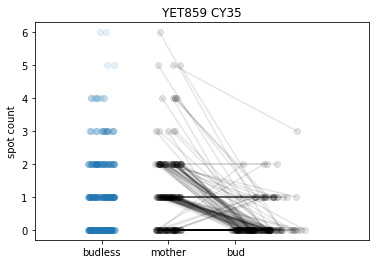

In [32]:
budless = df[df['has_bud']==0]
xaxis = [np.random.uniform(-.2,.2) for _ in range(len(budless))]
plt.scatter(xaxis, budless['cell_spots'],alpha=0.1)

budded = df[df['has_bud']==1]
for ix, row in budded.iterrows():
    plt.plot((1+np.random.uniform(-0.2,0.2),2+row['bud_size']/np.max(df['bud_size'])+np.random.uniform(-0.1,0.1)), (row['mother_spots'], row['bud_spots']), '-o', c='k', alpha=0.1)

plt.xlim(-1,4)
plt.gca().set_xticks([0,1,2],['budless', 'mother', 'bud'])
plt.gca().set_ylabel('spot count')
plt.gca().set_title('YET859 CY35')

#save plot as png
#plt.savefig(r'G:\FISH\ASH1-CLB2 bud marker\220428\YET859_2\Results\Spot analysis\YET859_CY35.png')

Text(0.5, 1.0, 'YET859 CY35')

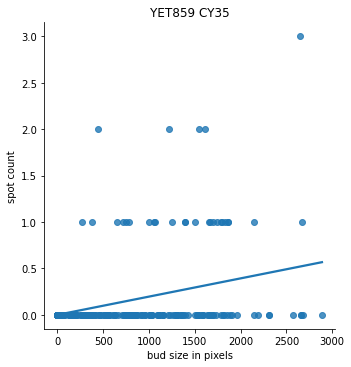

In [35]:
_ = sns.lmplot(x='bud_size', y='bud_spots', data=df, ci=None)
plt.gca().set_xlabel('bud size in pixels')
plt.gca().set_ylabel('spot count')
plt.gca().set_title('YET859 CY35')

Text(0, 0.5, 'spot count')

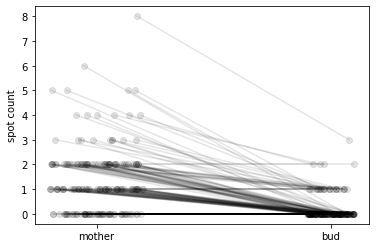

In [34]:
budded = df[df['has_bud']==1]
for ix, row in budded.iterrows():
    plt.plot((1+np.random.uniform(-0.2,0.2),2+np.random.uniform(-0.1,0.1)), (row['cell_spots'], row['bud_spots']), '-o', c='k', alpha=0.1)
plt.gca().set_xticks([1,2],['mother', 'bud'])
plt.gca().set_ylabel('spot count')


### Combine dataframes from two experiments into one

In [3]:
df1 = pd.read_excel (r'G:\FISH\ASH1-CLB2 bud marker\220428\YET859_1\Results\Spot analysis\YET859_CY35_df.xlsx')
df2 = pd.read_excel (r'G:\FISH\ASH1-CLB2 bud marker\220428\YET859_2\Results\Spot analysis\YET859_CY35_df.xlsx')
df_c = pd.concat([df1, df2])

df_c.to_excel(r'G:\FISH\ASH1-CLB2 bud marker\220428\YET859_2\Results\Spot analysis\YET859_CY35_df_combined.xlsx')

budded1 = pd.read_excel (r'G:\FISH\ASH1-CLB2 bud marker\220407\YET863_1\Results\Spot analysis\YET863_CY35_budded.xlsx')
budded2 = pd.read_excel (r'G:\FISH\ASH1-CLB2 bud marker\220407\YET863_2\Results\Spot analysis\YET863_CY35_budded.xlsx')
budded_c = pd.concat([budded1, budded2])

budded_c.to_excel(r'G:\FISH\ASH1-CLB2 bud marker\220407\YET863_2\Results\Spot analysis\YET863_CY35_budded_combined.xlsx')

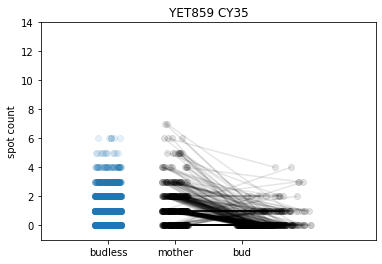

In [6]:
budless = df_c[df_c['has_bud']==0]
xaxis = [np.random.uniform(-.2,.2) for _ in range(len(budless))]
plt.scatter(xaxis, budless['cell_spots'],alpha=0.1)

budded = df_c[df_c['has_bud']==1]
for ix, row in budded.iterrows():
    plt.plot((1+np.random.uniform(-0.2,0.2),2+row['bud_size']/np.max(df_c['bud_size'])+np.random.uniform(-0.1,0.1)), (row['mother_spots'], row['bud_spots']), '-o', c='k', alpha=0.1)

plt.xlim(-1,4)
plt.ylim(-1,14)
plt.gca().set_xticks([0,1,2],['budless', 'mother', 'bud'])
plt.gca().set_ylabel('spot count')
plt.gca().set_title('YET859 CY35')

plt.savefig(r'G:\FISH\ASH1-CLB2 bud marker\220428\YET859_2\Results\Spot analysis\YET859_all_CY35_combined.png')

In [ ]:
_ = sns.lmplot(x='bud_size', y='bud_spots', data=df_c, ci=None)
plt.gca().set_xlabel('bud size in pixels')
plt.gca().set_ylabel('spot count')
plt.gca().set_title('YET859 CY35')

In [ ]:
budded = budded_c
for ix, row in budded.iterrows():
    plt.plot((1+np.random.uniform(-0.2,0.2),2+np.random.uniform(-0.1,0.1)), (row['cell_spots'], row['bud_spots']), '-o', c='k', alpha=0.1)
plt.gca().set_xticks([1,2],['mother', 'bud'])
plt.gca().set_ylabel('spot count')
print("y=%.6fx+(%.6f)"%(z[0],z[1]))